# Explanation of the data used to solve the problem

As the first part of this project to find the optimal location for an Indian restaurant in London. It is first needed to analyze the city's most typical venues by neighborhood, so it is possible to have an idea of which are the actual leisure places where people go spend their time. To begin this analysis, neighborhood clusters will be created and their venues analysed in similarity terms.

Once the most frequent venues per neighborhood get extracted, for the second part of this project a segmentation by nationality of the people living in each neighborhood will be carried out, in order to determine in which neighborhood would be more advisable to open a Indian food restaurant based on the results of the previous segmentation and the analised venues.

For this project, the data that will be used to analyse the venues comes from the Foursquare API and the Wikipedia's Ethnic groups in London webpage. This project will be devoloped using the Python 3.6 programing language as the main working tool. To have access to the data used in this part, please refer to the first notebook: "Optimal location for an Indian restaurant". The data used in this motebook must be generated in the first notebook.

## Importing Libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium

print('Libraries imported.')

     |████████████████████████████████| 92kB 11.6MB/s eta 0:00:01
Libraries imported.


## Read and Explore the Data

In [3]:
df = pd.read_csv('London population.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population
0,Newham,42484,30307,37262,3930,19912,133895
1,Redbridge,45660,31051,16011,3000,20781,116503
2,Brent,58017,14381,1749,3250,28589,105986
3,Tower Hamlets,6787,2442,81377,8109,5786,104501
4,Harrow,63051,7797,1378,2629,26953,101808


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
London Borough            20 non-null object
Indian Population         20 non-null int64
Pakistani Population      20 non-null int64
Bangladeshi Population    20 non-null int64
Chinese Population        20 non-null int64
Other Asian Population    20 non-null int64
Total Asian Population    20 non-null int64
dtypes: int64(6), object(1)
memory usage: 1.2+ KB


In [5]:
df.isnull().sum()

London Borough            0
Indian Population         0
Pakistani Population      0
Bangladeshi Population    0
Chinese Population        0
Other Asian Population    0
Total Asian Population    0
dtype: int64

In [6]:
coordinates_df = pd.DataFrame( data = {

'Neighborhood' : ['Newham', 'Redbridge', 'Brent', 'Tower Hamlets', 'Harrow',
                'Ealing', 'Hounslow', 'Hillingdon', 'Barnet', 'Croydon', 'Waltham Forest',
                'Merton', 'Camden', 'Enfield', 'Wandsworth', 'Westminster', 'Greenwich',
                'Barking and Dagenham', 'Southwark', 'Kingston Upon Thames'],
'Latitude' : ['51.5255','51.5901','51.5673','51.5203','51.5806','51.5131','51.4609','51.5352','51.6251','51.3762','51.5886',
             '51.4098','51.5517','51.6636','51.4571','51.4975','51.4934','51.5465','51.4834','51.4123'],
'Longitude' : ['0.0352','0.0819','-0.2711','-0.0293','-0.3420','-0.3256','-0.3731','-0.4481','-0.1529','-0.0982','-0.0118',
              '-0.2108','-0.1588','-0.1043','-0.1818','-0.1357','0.0098','0.1293','-0.0821','-0.3007']})

In [8]:
coordinates_df.head()

,Neighborhood,Latitude,Longitude
0,Newham,51.5255,0.0352
1,Redbridge,51.5901,0.0819
2,Brent,51.5673,-0.2711
3,Tower Hamlets,51.5203,-0.0293
4,Harrow,51.5806,-0.3420


In [9]:
coordinates_df.info

<bound method DataFrame.info of             Neighborhood Latitude Longitude
0                 Newham  51.5255    0.0352
1              Redbridge  51.5901    0.0819
2                  Brent  51.5673   -0.2711
3          Tower Hamlets  51.5203   -0.0293
4                 Harrow  51.5806   -0.3420
5                 Ealing  51.5131   -0.3256
6               Hounslow  51.4609   -0.3731
7             Hillingdon  51.5352   -0.4481
8                 Barnet  51.6251   -0.1529
9                Croydon  51.3762   -0.0982
10        Waltham Forest  51.5886   -0.0118
11                Merton  51.4098   -0.2108
12                Camden  51.5517   -0.1588
13               Enfield  51.6636   -0.1043
14            Wandsworth  51.4571   -0.1818
15           Westminster  51.4975   -0.1357
16             Greenwich  51.4934    0.0098
17  Barking and Dagenham  51.5465    0.1293
18             Southwark  51.4834   -0.0821
19  Kingston Upon Thames  51.4123   -0.3007>

In [10]:
coordinates_df['Latitude'] = coordinates_df['Latitude'].astype('float', errors = 'ignore')
coordinates_df['Longitude'] = coordinates_df['Longitude'].astype('float', errors = 'ignore')
coordinates_df.dtypes

Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

## Finding the Latitude and Longtitude of London

In [11]:
address = 'London, London'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinates of London are 51.5073219, -0.1276474.


## Creating of Map of London and the Neighborhoods

In [13]:
London_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(coordinates_df['Latitude'], coordinates_df['Longitude'], coordinates_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(London_map)  
    
London_map


## Using Foursquare Data to explore the neighborhoods

CLIENT_ID = 'YG1TKWPHECOQQWLO3ICSIAXBQLVX24ZNVC1XRADRCXCNQFLC' # Foursquare ID
CLIENT_SECRET = 'V0MK3UMF1MN4N3F4W1O1BDVDMAMU0LC5T4QVNANSXS5T5XUY' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [15]:
coordinates_df.loc[0, 'Neighborhood']

'Newham'

In [16]:
neighborhood_latitude = coordinates_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = coordinates_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = coordinates_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Newham are 51.5255, 0.0352.


## Discovering the Top Restaurant Venues in London

In [17]:
LIMIT= 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [18]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d59c2319929510025ab5cd8'},
 'response': {'headerLocation': 'Newham',
  'headerFullLocation': 'Newham, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 7,
  'suggestedBounds': {'ne': {'lat': 51.5300000045, 'lng': 0.04241929604043637},
   'sw': {'lat': 51.5209999955, 'lng': 0.027980703959563636}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e7b2628887783148edecd7d',
       'name': 'Delicious Café',
       'location': {'address': '566 Barking Road',
        'lat': 51.526416732217484,
        'lng': 0.030133265936175827,
        'labeledLatLngs': [{'label': 'display',
          'lat': 51.526416732217484,
          'lng': 0.030133265936175827}],
        'distance': 365,
        'postalCode': 'E13 9JU',
      

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Delicious Café,Café,51.526417,0.030133
1,Tesco Express,Grocery Store,51.527187,0.035118
2,Deep Blue Sea Fish & Chips,Fish & Chips Shop,51.525097,0.039410
3,West Ham Food Centre,Convenience Store,51.527451,0.031644
4,Ginny's Pie and Mash,Café,51.525705,0.029532


In [21]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

7 venues were returned by Foursquare.


In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
London_venues = getNearbyVenues(names= coordinates_df['Neighborhood'],
                                   latitudes= coordinates_df['Latitude'],
                                   longitudes= coordinates_df['Longitude']
                                  )

Newham
Redbridge
Brent
Tower Hamlets
Harrow
Ealing
Hounslow
Hillingdon
Barnet
Croydon
Waltham Forest
Merton
Camden
Enfield
Wandsworth
Westminster
Greenwich
Barking and Dagenham
Southwark
Kingston Upon Thames


In [24]:
print(London_venues.shape)
London_venues.head()

(402, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Newham,51.5255,0.0352,Delicious Café,51.526417,0.030133,Café
1,Newham,51.5255,0.0352,Tesco Express,51.527187,0.035118,Grocery Store
2,Newham,51.5255,0.0352,Deep Blue Sea Fish & Chips,51.525097,0.039410,Fish & Chips Shop
3,Newham,51.5255,0.0352,West Ham Food Centre,51.527451,0.031644,Convenience Store
4,Newham,51.5255,0.0352,Ginny's Pie and Mash,51.525705,0.029532,Café


In [25]:
London_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Barking and Dagenham,3,3,3,3,3,3
Barnet,4,4,4,4,4,4
Brent,7,7,7,7,7,7
Camden,24,24,24,24,24,24
Croydon,58,58,58,58,58,58
Ealing,21,21,21,21,21,21
Enfield,5,5,5,5,5,5
Greenwich,22,22,22,22,22,22
Harrow,27,27,27,27,27,27


In [26]:
# one hot encoding
london_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = London_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]
london_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bookstore,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Canal Lock,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Electronics Store,Event Service,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Furniture / Home Store,Gastropub,Gift Shop,Go Kart Track,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health Food Store,Home Service,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Locksmith,Malay Restaurant,Market,Martial Arts Dojo,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Nightclub,Park,Pedestrian Plaza,Persian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Sandwich Place,Shopping Mall,Skate Park,Smoothie Shop,Spa,Sporting Goods Shop,Stationery Store,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Track Stadium,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Wine Shop,Women's Store
0,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
london_onehot.shape

(402, 127)

In [28]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bookstore,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Canal Lock,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Electronics Store,Event Service,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Furniture / Home Store,Gastropub,Gift Shop,Go Kart Track,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health Food Store,Home Service,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Locksmith,Malay Restaurant,Market,Martial Arts Dojo,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Nightclub,Park,Pedestrian Plaza,Persian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Sandwich Place,Shopping Mall,Skate Park,Smoothie Shop,Spa,Sporting Goods Shop,Stationery Store,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Track Stadium,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Wine Shop,Women's Store
0,Barking and Dagenham,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Barnet,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [29]:
london_grouped.shape

(20, 127)

## Finding the Top 5 Venues by Neighborhood

In [30]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham----
                        venue  freq
0  Construction & Landscaping  0.33
1                        Lake  0.33
2                        Park  0.33
3         American Restaurant  0.00
4                   Nightclub  0.00


----Barnet----
                 venue  freq
0                 Café  0.50
1             Bus Stop  0.25
2         Home Service  0.25
3  American Restaurant  0.00
4             Platform  0.00


----Brent----
                       venue  freq
0                Supermarket  0.14
1                Bus Station  0.14
2                       Café  0.14
3                 Food Truck  0.14
4  Middle Eastern Restaurant  0.14


----Camden----
         venue  freq
0  Pizza Place  0.08
1  Coffee Shop  0.08
2       Bakery  0.08
3    Gastropub  0.08
4         Café  0.08


----Croydon----
            venue  freq
0     Coffee Shop  0.19
1  Clothing Store  0.09
2        Platform  0.07
3       Bookstore  0.05
4             Pub  0.05


----Ealing----
                

## Sort the venues by descending order

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Using Pandas DF to sort to find the Top 10 Restaurants by Neighborhood

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Construction & Landscaping,Lake,Park,Women's Store,Food & Drink Shop,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Electronics Store
1,Barnet,Café,Home Service,Bus Stop,Women's Store,Food & Drink Shop,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Electronics Store
2,Brent,IT Services,Food Truck,Fast Food Restaurant,Café,Bus Station,Middle Eastern Restaurant,Supermarket,Grocery Store,Greek Restaurant,Dessert Shop
3,Camden,Gastropub,Bakery,Pizza Place,Coffee Shop,Café,American Restaurant,Bookstore,Wine Shop,Gym / Fitness Center,French Restaurant
4,Croydon,Coffee Shop,Clothing Store,Platform,Café,Pub,Bookstore,Hotel,Asian Restaurant,Sushi Restaurant,Bus Stop
5,Ealing,Hotel,Fast Food Restaurant,Supermarket,Coffee Shop,Grocery Store,Bagel Shop,Farmers Market,Furniture / Home Store,Park,Bakery
6,Enfield,Pub,Coffee Shop,Restaurant,Auto Workshop,Tennis Court,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Service
7,Greenwich,Park,Chinese Restaurant,Portuguese Restaurant,Szechuan Restaurant,Convenience Store,Nightclub,Pub,Movie Theater,Coffee Shop,Café
8,Harrow,Coffee Shop,Gym,Clothing Store,Pizza Place,Women's Store,Movie Theater,Rock Climbing Spot,Department Store,Donut Shop,Middle Eastern Restaurant
9,Hillingdon,Chinese Restaurant,Construction & Landscaping,Martial Arts Dojo,Breakfast Spot,Gym,Women's Store,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant


## Clustering of the Neighborhoods

In [33]:
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(london_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

In [34]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
# optimal_k

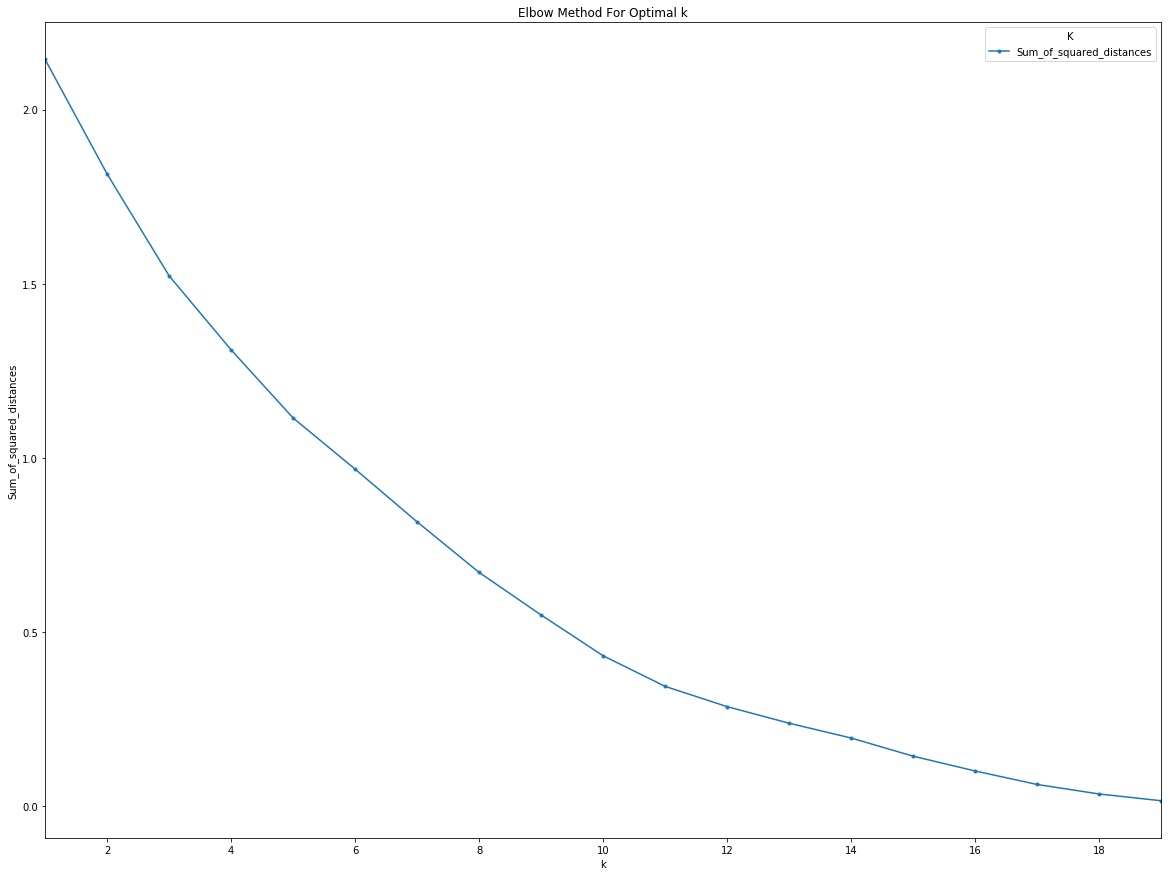

In [35]:
optimal_k.plot(kind = 'line', figsize = (20, 15), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

6 is best suitable K Value 

In [36]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 4, 3, 3, 3, 3, 3, 3, 3, 5], dtype=int32)

## Organizing the Data by Nationalities and most common restaurants

In [37]:
london_merged = df.merge(neighborhoods_venues_sorted, how='inner', left_on='London Borough', right_on='Neighborhood')
london_merged['Cluster Labels'] = kmeans.labels_
london_merged

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Newham,42484,30307,37262,3930,19912,133895,Newham,Grocery Store,Café,Convenience Store,Fish & Chips Shop,Park,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,2
1,Redbridge,45660,31051,16011,3000,20781,116503,Redbridge,Café,Supermarket,Pub,Coffee Shop,Sandwich Place,Park,Middle Eastern Restaurant,Fast Food Restaurant,Indian Restaurant,Pharmacy,4
2,Brent,58017,14381,1749,3250,28589,105986,Brent,IT Services,Food Truck,Fast Food Restaurant,Café,Bus Station,Middle Eastern Restaurant,Supermarket,Grocery Store,Greek Restaurant,Dessert Shop,3
3,Tower Hamlets,6787,2442,81377,8109,5786,104501,Tower Hamlets,Recreation Center,Go Kart Track,Skate Park,Canal Lock,Museum,Thrift / Vintage Store,Track Stadium,Middle Eastern Restaurant,Persian Restaurant,Coffee Shop,3
4,Harrow,63051,7797,1378,2629,26953,101808,Harrow,Coffee Shop,Gym,Clothing Store,Pizza Place,Women's Store,Movie Theater,Rock Climbing Spot,Department Store,Donut Shop,Middle Eastern Restaurant,3
5,Ealing,48240,14711,1786,4132,31570,100439,Ealing,Hotel,Fast Food Restaurant,Supermarket,Coffee Shop,Grocery Store,Bagel Shop,Farmers Market,Furniture / Home Store,Park,Bakery,3
6,Hounslow,48161,13676,2189,2405,20826,87257,Hounslow,Pizza Place,Auto Garage,Grocery Store,Middle Eastern Restaurant,Indian Restaurant,Diner,Doner Restaurant,Donut Shop,Dessert Shop,Food & Drink Shop,3
7,Hillingdon,36795,9200,2639,2889,17730,69253,Hillingdon,Chinese Restaurant,Construction & Landscaping,Martial Arts Dojo,Breakfast Spot,Gym,Women's Store,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,3
8,Barnet,27920,5344,2215,8259,22180,65918,Barnet,Café,Home Service,Bus Stop,Women's Store,Food & Drink Shop,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Electronics Store,3
9,Croydon,24660,10865,2570,3925,17607,59627,Croydon,Coffee Shop,Clothing Store,Platform,Café,Pub,Bookstore,Hotel,Asian Restaurant,Sushi Restaurant,Bus Stop,5


In [38]:
london_merged[['Latitude', 'Longitude']] = coordinates_df[['Latitude', 'Longitude']]
london_merged['Latitude'] = london_merged['Latitude'].astype(float)
london_merged['Longitude'] = london_merged['Longitude'].astype(float)
london_merged

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
0,Newham,42484,30307,37262,3930,19912,133895,Newham,Grocery Store,Café,Convenience Store,Fish & Chips Shop,Park,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,2,51.5255,0.0352
1,Redbridge,45660,31051,16011,3000,20781,116503,Redbridge,Café,Supermarket,Pub,Coffee Shop,Sandwich Place,Park,Middle Eastern Restaurant,Fast Food Restaurant,Indian Restaurant,Pharmacy,4,51.5901,0.0819
2,Brent,58017,14381,1749,3250,28589,105986,Brent,IT Services,Food Truck,Fast Food Restaurant,Café,Bus Station,Middle Eastern Restaurant,Supermarket,Grocery Store,Greek Restaurant,Dessert Shop,3,51.5673,-0.2711
3,Tower Hamlets,6787,2442,81377,8109,5786,104501,Tower Hamlets,Recreation Center,Go Kart Track,Skate Park,Canal Lock,Museum,Thrift / Vintage Store,Track Stadium,Middle Eastern Restaurant,Persian Restaurant,Coffee Shop,3,51.5203,-0.0293
4,Harrow,63051,7797,1378,2629,26953,101808,Harrow,Coffee Shop,Gym,Clothing Store,Pizza Place,Women's Store,Movie Theater,Rock Climbing Spot,Department Store,Donut Shop,Middle Eastern Restaurant,3,51.5806,-0.3420
5,Ealing,48240,14711,1786,4132,31570,100439,Ealing,Hotel,Fast Food Restaurant,Supermarket,Coffee Shop,Grocery Store,Bagel Shop,Farmers Market,Furniture / Home Store,Park,Bakery,3,51.5131,-0.3256
6,Hounslow,48161,13676,2189,2405,20826,87257,Hounslow,Pizza Place,Auto Garage,Grocery Store,Middle Eastern Restaurant,Indian Restaurant,Diner,Doner Restaurant,Donut Shop,Dessert Shop,Food & Drink Shop,3,51.4609,-0.3731
7,Hillingdon,36795,9200,2639,2889,17730,69253,Hillingdon,Chinese Restaurant,Construction & Landscaping,Martial Arts Dojo,Breakfast Spot,Gym,Women's Store,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,3,51.5352,-0.4481
8,Barnet,27920,5344,2215,8259,22180,65918,Barnet,Café,Home Service,Bus Stop,Women's Store,Food & Drink Shop,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Electronics Store,3,51.6251,-0.1529
9,Croydon,24660,10865,2570,3925,17607,59627,Croydon,Coffee Shop,Clothing Store,Platform,Café,Pub,Bookstore,Hotel,Asian Restaurant,Sushi Restaurant,Bus Stop,5,51.3762,-0.0982


## Visualizing the Clusters

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examing each Cluster

In [42]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Indian Population'], ascending = False)
#Cluster 1

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
10,Waltham Forest,9134,26347,4632,2579,11697,54389,Waltham Forest,Grocery Store,Pub,Coffee Shop,Thrift / Vintage Store,Concert Hall,Pizza Place,Field,Pool,Vegetarian / Vegan Restaurant,Gym,0,51.5886,-0.0118
17,Barking and Dagenham,7436,8007,7701,1315,5135,29594,Barking and Dagenham,Construction & Landscaping,Lake,Park,Women's Store,Food & Drink Shop,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Electronics Store,0,51.5465,0.1293


In [43]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Indian Population'], ascending = False)
#Cluster 2

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
13,Enfield,11648,2594,5599,2588,12464,34893,Enfield,Pub,Coffee Shop,Restaurant,Auto Workshop,Tennis Court,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Service,1,51.6636,-0.1043
14,Wandsworth,8642,9718,1493,3715,9770,33338,Wandsworth,Pub,Grocery Store,Café,Park,Coffee Shop,Pizza Place,Bus Stop,Indian Restaurant,Hotel,Doner Restaurant,1,51.4571,-0.1818
15,Westminster,7213,2328,6299,5917,10105,31862,Westminster,Hotel,Sandwich Place,Coffee Shop,Theater,Indian Restaurant,Salad Place,Restaurant,Hotel Bar,Juice Bar,Café,1,51.4975,-0.1357
12,Camden,6083,1489,12503,6493,8878,35446,Camden,Gastropub,Bakery,Pizza Place,Coffee Shop,Café,American Restaurant,Bookstore,Wine Shop,Gym / Fitness Center,French Restaurant,1,51.5517,-0.1588
18,Southwark,5819,1623,3912,8074,7764,27192,Southwark,Pub,Lake,Building,Café,Skate Park,Park,Donut Shop,Electronics Store,Event Service,Fish & Chips Shop,1,51.4834,-0.0821


In [44]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Indian Population'], ascending = False)
#Cluster 3

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
0,Newham,42484,30307,37262,3930,19912,133895,Newham,Grocery Store,Café,Convenience Store,Fish & Chips Shop,Park,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,2,51.5255,0.0352


In [45]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Indian Population'], ascending = False)
#Cluster 4

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
4,Harrow,63051,7797,1378,2629,26953,101808,Harrow,Coffee Shop,Gym,Clothing Store,Pizza Place,Women's Store,Movie Theater,Rock Climbing Spot,Department Store,Donut Shop,Middle Eastern Restaurant,3,51.5806,-0.3420
2,Brent,58017,14381,1749,3250,28589,105986,Brent,IT Services,Food Truck,Fast Food Restaurant,Café,Bus Station,Middle Eastern Restaurant,Supermarket,Grocery Store,Greek Restaurant,Dessert Shop,3,51.5673,-0.2711
5,Ealing,48240,14711,1786,4132,31570,100439,Ealing,Hotel,Fast Food Restaurant,Supermarket,Coffee Shop,Grocery Store,Bagel Shop,Farmers Market,Furniture / Home Store,Park,Bakery,3,51.5131,-0.3256
6,Hounslow,48161,13676,2189,2405,20826,87257,Hounslow,Pizza Place,Auto Garage,Grocery Store,Middle Eastern Restaurant,Indian Restaurant,Diner,Doner Restaurant,Donut Shop,Dessert Shop,Food & Drink Shop,3,51.4609,-0.3731
7,Hillingdon,36795,9200,2639,2889,17730,69253,Hillingdon,Chinese Restaurant,Construction & Landscaping,Martial Arts Dojo,Breakfast Spot,Gym,Women's Store,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,3,51.5352,-0.4481
8,Barnet,27920,5344,2215,8259,22180,65918,Barnet,Café,Home Service,Bus Stop,Women's Store,Food & Drink Shop,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Electronics Store,3,51.6251,-0.1529
11,Merton,8106,7337,2216,2618,15866,36143,Merton,Grocery Store,Pub,Coffee Shop,Café,Locksmith,Event Service,Park,Rental Car Location,Bakery,Train Station,3,51.4098,-0.2108
16,Greenwich,7836,2594,1645,5061,12758,29894,Greenwich,Park,Chinese Restaurant,Portuguese Restaurant,Szechuan Restaurant,Convenience Store,Nightclub,Pub,Movie Theater,Coffee Shop,Café,3,51.4934,0.0098
3,Tower Hamlets,6787,2442,81377,8109,5786,104501,Tower Hamlets,Recreation Center,Go Kart Track,Skate Park,Canal Lock,Museum,Thrift / Vintage Store,Track Stadium,Middle Eastern Restaurant,Persian Restaurant,Coffee Shop,3,51.5203,-0.0293
19,Kingston Upon Thames,6325,3009,892,2883,13043,26152,Kingston Upon Thames,Coffee Shop,Café,Department Store,Hotel,Bookstore,Clothing Store,Women's Store,Fast Food Restaurant,Gym / Fitness Center,Supermarket,3,51.4123,-0.3007


In [47]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Indian Population'], ascending = False)
#Cluster 5

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
1,Redbridge,45660,31051,16011,3000,20781,116503,Redbridge,Café,Supermarket,Pub,Coffee Shop,Sandwich Place,Park,Middle Eastern Restaurant,Fast Food Restaurant,Indian Restaurant,Pharmacy,4,51.5901,0.0819


In [49]:
london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Indian Population'], ascending = False)
#Cluster 6

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
9,Croydon,24660,10865,2570,3925,17607,59627,Croydon,Coffee Shop,Clothing Store,Platform,Café,Pub,Bookstore,Hotel,Asian Restaurant,Sushi Restaurant,Bus Stop,5,51.3762,-0.0982


## Conclusion

As far as we are able to see with this data, the highest amount of Indian population is located at Harrow represented in cluster 1.

If a deeper exam is performed into this cluster, it is noticeable that the living population in here ranks it the 5th most Asian inhabited borough. Apart of this fact, a strange closeness to Indian food can be found as the 8th most prominent venue in here is Middle Eastern restaurant which, while not being an Indian restaurant is the closest match to an Indian cuisine restaurant.

By following this logic, if we would like to open a new Indian restaurant in the city or any kind of restaurant in fact, it would only be necessary to find a where are the restaurants similar the one we want to open, study the population in that area, and find similar clusters of population in the city that don't have yet or have very few restaurants like the one we would like to open.

In this example, clusters 1 could make a good match for our target population. Looking at the venues in this cluster, it is possible to find two Indian restaurants, and a good bunch of Middle Eastern restaurants and coffee shops. So, in this cluster, it is possible to state that the existing restaurants matches the population's nationalities and tastes.

In conclusion, and taking into consideration the explanations given above as well as the data, it is highly possible that cluster 1 could be a good place to open our Indian restaurants. As explained above, the same logic could apply to open other kind of restaurants or business in any other area of the city. It is only necessary to examine the existing businesses in our target area, and study the population, then compare these 2 factors with the same ones in areas where there are existing business like the one we want to open, and then verify if the matching is correct.